In [1]:
from sec_api import QueryApi
import pandas as pd

df = pd.read_csv('finbert.csv')
df

,ticker,year_1_before,year_2_before,car,bhar,prccd,dvi
0,MIXT,2017,2016,-0.212499,-0.211695,4.66,0.2843
1,MIXT,2017,2016,-0.212499,-0.211695,4.68,0.2843
2,MIXT,2017,2016,-0.212499,-0.211695,4.84,0.2848
3,MIXT,2017,2016,-0.212499,-0.211695,4.57,0.2848
4,MIXT,2017,2016,-0.212499,-0.211695,4.52,0.2848
...,...,...,...,...,...,...,...
46592,HOLI,2016,2015,-0.003185,-0.005521,15.79,0.3200
46593,HOLI,2016,2015,-0.003185,-0.005521,16.03,0.3200
46594,HOLI,2016,2015,-0.003185,-0.005521,15.96,0.3200
46595,HOLI,2016,2015,-0.003185,-0.005521,15.73,0.3200


In [2]:
ticker_names = df['ticker'].unique()

for ticker in ticker_names:
    print(ticker)

MIXT
AAPL
IMOS
JCS
ERIC
MGIC
SPNS
DAKT
TESS
STM
TIVO
APH
FORTY
MNDO
UMC
SPIL
ITRN
HIMX
HOLI


In [3]:
filtered_df = df[df['ticker'] == 'TIVO']
print(filtered_df)

      ticker  year_1_before  year_2_before       car      bhar  prccd   dvi
23246   TIVO           2018           2017 -0.239076 -0.206391  21.00  0.72
23247   TIVO           2018           2017 -0.239076 -0.206391  20.05  0.72
23248   TIVO           2018           2017 -0.239076 -0.206391  19.60  0.72
23249   TIVO           2018           2017 -0.239076 -0.206391  19.75  0.72
23250   TIVO           2018           2017 -0.239076 -0.206391  19.50  0.72
...      ...            ...            ...       ...       ...    ...   ...
23606   TIVO           2018           2017 -0.239076 -0.206391   6.92  0.00
23607   TIVO           2018           2017 -0.239076 -0.206391   6.99  0.00
23608   TIVO           2018           2017 -0.239076 -0.206391   6.94  0.00
23609   TIVO           2018           2017 -0.239076 -0.206391   6.41  0.00
23610   TIVO           2018           2017 -0.239076 -0.206391   6.09  0.00

[365 rows x 7 columns]


In [4]:
from finbert_embedding.embedding import FinbertEmbedding
import pandas as pd

2023-05-18 12:50:28.713018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 12:50:29.275422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Due to limitations with how much we can pull, we will focus more on AAPL

In [5]:
from sec_api import QueryApi
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

# Initialize SEC API client
queryApi = QueryApi(api_key="6392e5014222c282c60a9d4bade6c43ae9487f8288ef1848afd0c5f21b8c4295")

# Define SEC API query
query = {
  "query": { "query_string": {
      "query": "ticker:AAPL AND filedAt:{2010-01-01 TO 2020-12-31} AND formType:\"10-K\""
        } 
    },
    "from": "0",
    "size": "10",
    "sort": [{"filedAt": {"order": "desc"}}],
}   
# get SEC filings
filings = queryApi.get_filings(query)

#  Finbert model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

#  sentiment analysis on filings
sentences = [filing['description'] for filing in filings['filings']]
inputs = tokenizer(sentences, return_tensors="pt", padding=True)
outputs = finbert(**inputs)[0]

# return sentiment analysis results
labels = {0:'neutral', 1:'positive', 2:'negative'}
for idx, sent in enumerate(sentences):
    print(sent, '----', labels[np.argmax(outputs.detach().numpy()[idx])])


Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral
Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405] ---- neutral


In [6]:
'''overall neutral so, but we can break down this to only focusing on 
MD&A'''

'overall neutral so, but we can break down this to only focusing on \nMD&A'

In [7]:
from sec_api import ExtractorApi

extractorApi = ExtractorApi("7eabb4b238f3124dc42cf6e0b5e70d8752272bf886120429c3a49961459f2e64")
#2018 10k
filing_url_10k = 'https://www.sec.gov/Archives/edgar/data/320193/000032019318000145/a10-k20189292018.htm'
# get the original HTML of section 7 "Management’s Discussion and Analysis of Financial Condition and Results of Operations"
section_text = extractorApi.get_section(filing_url_10k, "7", "text")


In [8]:
section_text

" Item 7. \n\nManagement&#8217;s Discussion and Analysis of Financial Condition and Results of Operations \n\n##TABLE_END This section and other parts of this Annual Report on Form 10-K (&#8220;Form 10-K&#8221;) contain forward-looking statements, within the meaning of the Private Securities Litigation Reform Act of 1995, that involve risks and uncertainties. Forward-looking statements provide current expectations of future events based on certain assumptions and include any statement that does not directly relate to any historical or current fact. Forward-looking statements can also be identified by words such as &#8220;future,&#8221; &#8220;anticipates,&#8221; &#8220;believes,&#8221; &#8220;estimates,&#8221; &#8220;expects,&#8221; &#8220;intends,&#8221; &#8220;plans,&#8221; &#8220;predicts,&#8221; &#8220;will,&#8221; &#8220;would,&#8221; &#8220;could,&#8221; &#8220;can,&#8221; &#8220;may,&#8221; and similar terms. Forward-looking statements are not guarantees of future performance an

 Item 7. 

Management&#8217;s Discussion and Analysis of Financial Condition and Results of Operations 

##TABLE_END This section and other parts of this Annual Report on Form 10-K (&#8220;Form 10-K&#8221;) contain forward-looking statements, within the meaning of the Private Securities Litigation Reform Act of 1995, that involve risks and uncertainties. Forward-looking statements provide current expectations of future events based on certain assumptions and include any statement that does not directly rela ---- neutral
te to any historical or current fact. Forward-looking statements can also be identified by words such as &#8220;future,&#8221; &#8220;anticipates,&#8221; &#8220;believes,&#8221; &#8220;estimates,&#8221; &#8220;expects,&#8221; &#8220;intends,&#8221; &#8220;plans,&#8221; &#8220;predicts,&#8221; &#8220;will,&#8221; &#8220;would,&#8221; &#8220;could,&#8221; &#8220;can,&#8221; &#8220;may,&#8221; and similar terms. Forward-looking statements are not guarantees of future perfo

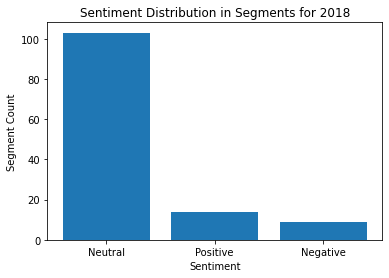

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

section_text = section_text
#break text into sections due to word limit
max_segment_length = 512
segments = [section_text[i: i + max_segment_length] for i in range(0, len(section_text), max_segment_length)]

neutral_count = 0
positive_count = 0
negative_count = 0

for segment in segments:
    inputs = tokenizer(segment, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]

    labels = {0: 'neutral', 1: 'positive', 2: 'negative'}
    predictions = np.argmax(outputs.detach().numpy(), axis=1)
    for idx, pred in enumerate(predictions):
        print(segment, '----', labels[pred])
        if pred == 0:  # Check if neutral
            neutral_count += 1
        elif pred == 1:  # Check if  positive
            positive_count += 1
        elif pred == 2:  # Checknegative
            negative_count += 1

print("Number of neutral segments:", neutral_count)
print("Number of positive segments:", positive_count)
print("Number of negative segments:", negative_count)

# Create histogram
sentiment_labels = ['Neutral', 'Positive', 'Negative']
segment_counts = [neutral_count, positive_count, negative_count]

plt.bar(sentiment_labels, segment_counts)
plt.xlabel('Sentiment')
plt.ylabel('Segment Count')
plt.title('Sentiment Distribution in Segments for 2018')
plt.show()


In [10]:
from sec_api import ExtractorApi

extractorApi = ExtractorApi("7eabb4b238f3124dc42cf6e0b5e70d8752272bf886120429c3a49961459f2e64")
#filling for 2019
filing_url_10k = 'https://www.sec.gov/Archives/edgar/data/320193/000032019319000119/a10-k20199282019.htm'
# get the original HTML of section 7 "Management’s Discussion and Analysis of Financial Condition and Results of Operations"
section_text = extractorApi.get_section(filing_url_10k, "7", "text")



 Item 7. 

Management&#8217;s Discussion and Analysis of Financial Condition and Results of Operations 

##TABLE_END This section and other parts of this Annual Report on Form 10-K (&#8220;Form 10-K&#8221;) contain forward-looking statements, within the meaning of the Private Securities Litigation Reform Act of 1995, that involve risks and uncertainties. Forward-looking statements provide current expectations of future events based on certain assumptions and include any statement that does not directly rela ---- neutral
te to any historical or current fact. Forward-looking statements can also be identified by words such as &#8220;future,&#8221; &#8220;anticipates,&#8221; &#8220;believes,&#8221; &#8220;estimates,&#8221; &#8220;expects,&#8221; &#8220;intends,&#8221; &#8220;plans,&#8221; &#8220;predicts,&#8221; &#8220;will,&#8221; &#8220;would,&#8221; &#8220;could,&#8221; &#8220;can,&#8221; &#8220;may,&#8221; and similar terms. Forward-looking statements are not guarantees of future perfo

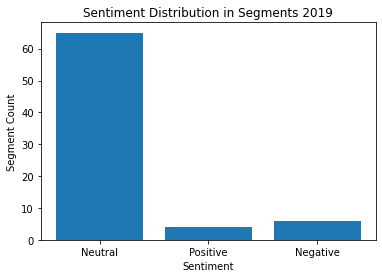

In [12]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

section_text = section_text
max_segment_length = 512
segments = [section_text[i: i + max_segment_length] for i in range(0, len(section_text), max_segment_length)]

neutral_count = 0
positive_count = 0
negative_count = 0

for segment in segments:
    inputs = tokenizer(segment, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]

    labels = {0: 'neutral', 1: 'positive', 2: 'negative'}
    predictions = np.argmax(outputs.detach().numpy(), axis=1)
    for idx, pred in enumerate(predictions):
        print(segment, '----', labels[pred])
        if pred == 0:  #  neutral
            neutral_count += 1
        elif pred == 1:  # Check  positive
            positive_count += 1
        elif pred == 2:  # Check if negative
            negative_count += 1

print("Number of neutral segments:", neutral_count)
print("Number of positive segments:", positive_count)
print("Number of negative segments:", negative_count)
# Create histogram
sentiment_labels = ['Neutral', 'Positive', 'Negative']
segment_counts = [neutral_count, positive_count, negative_count]

plt.bar(sentiment_labels, segment_counts)
plt.xlabel('Sentiment')
plt.ylabel('Segment Count')
plt.title('Sentiment Distribution in Segments 2019')
plt.show()

In [13]:

queryApi = QueryApi(api_key="7eabb4b238f3124dc42cf6e0b5e70d8752272bf886120429c3a49961459f2e64")

query = {
  "query": { "query_string": {
      "query": "ticker:AAPL AND filedAt:{2018-01-01 TO 2019-12-31} AND formType:\"8-k\""
    } },
  "from": "0",
  "size": "10",
  "sort": [{ "filedAt": { "order": "desc" } }]
}

filings = queryApi.get_filings(query)
filings

{'total': {'value': 17, 'relation': 'eq'},
 'query': {'from': 0, 'size': 10},
 'filings': [{'id': '3dceda34ae3cc98d235e437ba99c2879',
   'accessionNo': '0001193125-19-292676',
   'cik': '320193',
   'ticker': 'AAPL',
   'companyName': 'Apple Inc.',
   'companyNameLong': 'Apple Inc. (Filer)',
   'formType': '8-K',
   'description': 'Form 8-K - Current report - Item 8.01 Item 9.01',
   'filedAt': '2019-11-15T06:02:24-05:00',
   'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/320193/000119312519292676/0001193125-19-292676.txt',
   'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/320193/0001193125-19-292676-index.htm',
   'linkToXbrl': '',
   'linkToFilingDetails': 'https://www.sec.gov/ix?doc=/Archives/edgar/data/320193/000119312519292676/d828969d8k.htm',
   'entities': [{'companyName': 'Apple Inc. (Filer)',
     'cik': '320193',
     'irsNo': '942404110',
     'stateOfIncorporation': 'CA',
     'fiscalYearEnd': '0928',
     'type': '8-K',
     'act': '34',
     'fileNo': '001-

In [14]:
#  Finbert model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

#  sentiment analysis on filings
sentences = [filing['description'] for filing in filings['filings']]
inputs = tokenizer(sentences, return_tensors="pt", padding=True)
outputs = finbert(**inputs)[0]

# return sentiment analysis results
labels = {0:'neutral', 1:'positive', 2:'negative'}
for idx, sent in enumerate(sentences):
    print(sent, '----', labels[np.argmax(outputs.detach().numpy()[idx])])



Form 8-K - Current report - Item 8.01 Item 9.01 ---- neutral
Form 8-K - Current report - Item 2.02 Item 9.01 ---- neutral
Form 8-K - Current report - Item 5.02 ---- neutral
Form 8-K - Current report - Item 8.01 Item 9.01 ---- neutral
Form 8-K - Current report - Item 2.02 Item 9.01 ---- neutral
Form 8-K - Current report - Item 2.02 Item 9.01 ---- neutral
Form 8-K - Current report - Item 5.07 ---- neutral
Form 8-K - Current report - Item 5.02 ---- neutral
Form 8-K - Current report - Item 2.02 Item 9.01 ---- neutral
Form 8-K - Current report - Item 2.02 Item 9.01 ---- neutral


In [15]:
'''althought there was some increase in negativity from 2018-2019, 
it was not signiciant enough to raise red flags'''

'althought there was some increase in negativity from 2018-2019, \nit was not signiciant enough to raise red flags'

In [16]:
from sec_api import ExtractorApi

extractorApi = ExtractorApi("7eabb4b238f3124dc42cf6e0b5e70d8752272bf886120429c3a49961459f2e64")
#filling for 2016
filing_url_10k = 'https://www.sec.gov/Archives/edgar/data/1088825/000108882516000243/tivo10-k13116.htm'
# get the standardized and cleaned text of section 1A "Risk Factors"
# get the original HTML of section 7 "Management’s Discussion and Analysis of Financial Condition and Results of Operations"
section_text = extractorApi.get_section(filing_url_10k, "7", "text")



 ITEM 7. 

MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS 

##TABLE_END

You should read the following discussion and analysis in conjunction with the consolidated financial statements and the accompanying notes included in this annual report and the section entitled &#8220;Risk Factors&#8221; in Item 1A, as well as other cautionary statements and risks described elsewhere in this report before deciding to purchase, sell or hold our common stock. 

Company Overview 

& ---- neutral
#32;We are a global leader in next-generation video technology and innovative cloud-based software-as-a-service solutions. The TiVo experience provides an all-in-one approach for navigating the &#8216;content chaos&#8217; by seamlessly combining live, recorded, VOD, and over-the-top (e.g. Netflix, Amazon, Hulu Plus, Vudu, and YouTube, among others) television into one intuitive user interface with simple universal search, discovery, viewing, and recording, creating the 

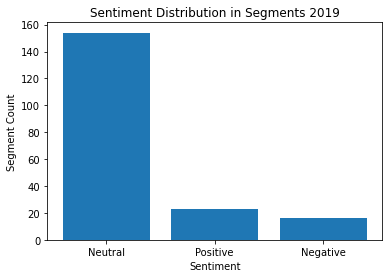

In [148]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

section_text = section_text
max_segment_length = 512
segments = [section_text[i: i + max_segment_length] for i in range(0, len(section_text), max_segment_length)]

neutral_count = 0
positive_count = 0
negative_count = 0

for segment in segments:
    inputs = tokenizer(segment, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]

    labels = {0: 'neutral', 1: 'positive', 2: 'negative'}
    predictions = np.argmax(outputs.detach().numpy(), axis=1)
    for idx, pred in enumerate(predictions):
        print(segment, '----', labels[pred])
        if pred == 0:  # Check if sentiment is neutral
            neutral_count += 1
        elif pred == 1:  # Check if sentiment is positive
            positive_count += 1
        elif pred == 2:  # Check if sentiment is negative
            negative_count += 1

print("Number of neutral segments:", neutral_count)
print("Number of positive segments:", positive_count)
print("Number of negative segments:", negative_count)
# Create histogram
sentiment_labels = ['Neutral', 'Positive', 'Negative']
segment_counts = [neutral_count, positive_count, negative_count]

plt.bar(sentiment_labels, segment_counts)
plt.xlabel('Sentiment')
plt.ylabel('Segment Count')
plt.title('Sentiment Distribution in Segments 2019')
plt.show()